# Bayesian linear regression

Demonstration of an agent performing Bayesian linear regression.

==========================================================================

* **Notebook dependencies**:
    * ...

* **Content**: Jupyter notebook accompanying Chapter 3 of the textbook "Fundamentals of Active Inference"

* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from numpy.linalg import inv
from pylab import colorbar
from scipy.stats import multivariate_normal
from types import SimpleNamespace

mpl.style.use("seaborn-deep")

We now turn to a Bayesian linear regression agent. In Bayesian linear regression, we are interested in solving the following inference problem:

$$
p_{\Sigma_{\theta \mid y}, \mu_{\theta \mid y}}(\boldsymbol{\theta} \mid \boldsymbol{y}) = \frac{p_{\sigma^2_y, X}(\boldsymbol{y} \mid \boldsymbol{\theta}) p_{\mu_{\theta}, \sigma^2_{\theta}}(\boldsymbol{\theta})}{p(\boldsymbol{y})}
$$

This tells us that we are interested in the posterior distribution over parameters. However, we are not just interested in deterministic values for $\beta_0$ and $\beta_1$. Rather we want to collect them into a vector $\boldsymbol{\theta} = \begin{bmatrix} \beta_0 & \beta_1 \end{bmatrix}^\top$ which we can represent with a multivariate normal distribution. This distribution is the posterior: Given what we have observed of the data, what is the distribution of the parameter vector? The variables of interest are represented as follows:

| Variable | Status     | Data type     |
|----------|------------|---------------|
| $x$      | observed   | deterministic |
| $y$      | observed   | probabilistic |
| $\theta$ | unobserved | **probabilistic** |
| $\phi$   | known      | deterministic |

We will the following specification for the generative process:


$$
    \mathscr{E} \triangleq
    \begin{cases}
        y^{(i)} = g_{\mathscr{E}}({{\boldsymbol{x}^*}^{(i)}}; \boldsymbol{\theta}^*) + \omega_y^*    & \text{Outcome generation} \\
        g_{\mathscr{E}}({{\boldsymbol{x}^*}^{(i)}}; \boldsymbol{\theta}^*) = {{\boldsymbol{x}^*}^{(i)}}^\top \boldsymbol{\theta^*} & \text{Linear generating function} \\
        \boldsymbol{\omega}_y^* \sim \mathcal{N}(\mu = 0, \sigma^2 = 1) & \text{Gaussian noise} \\
        \boldsymbol{\theta}^* = \left [{\beta^*}^{(0)} = 3, {\beta^*}^{(1)} = 2 \right ]^\top & \text{Linear parameters}
    \end{cases}
$$

and the corresponding generative model:

$$
    \mathcal{M} \triangleq
    \begin{cases}
        p_{\sigma^2_y, X}(\boldsymbol{y} \mid \boldsymbol{\theta}, \boldsymbol{X}) = \mathcal{N}(\boldsymbol{y}; \boldsymbol{X} \boldsymbol{\theta}, \boldsymbol{\Sigma}_y = \sigma^2_y \boldsymbol{I}) & \text{Likelihood} \\
        p_{\mu_\theta, \sigma^2_\theta}(\boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{x}; \boldsymbol{\mu}_\theta, \boldsymbol{\Sigma}_\theta = \sigma^2_\theta \boldsymbol{I}) & \text{Prior on } \theta \\
        \boldsymbol{\theta} = \left [\beta^{(0)}, \beta^{(1)} \right ]^\top  & \text{Linear parameters} \\ 
        \phi = \left \{\mu_{\theta}, \sigma^2_{\theta}, \sigma^2_{y} \right \}  & \text{Other parameters}
    \end{cases}
$$


Note that the likelihood takes in the data matrix $\boldsymbol{X}$ multiplied by $\boldsymbol{\theta}$. The output of this is a vector which means the likelihood is represented by a multivariate normal distribution. Likewise, the prior and posterior are also multivariate normal distributions.

We will use the environment defined in Notebook 3.3.

In [2]:
class StaticEnvironment:
    def __init__(self, params: dict) -> None:
        self.params = SimpleNamespace(**params)
        
    def _noise(self):
        return np.random.normal(loc=0, scale=self.params.y_star_std)
    
    def _generating_function(self, x_star: np.array) -> float:
        return x_star.T @ self.params.theta_star
    
    def generate(self, x_star: float) -> float:
        x_star = np.insert(x_star, 0, 1)
        return self._generating_function(x_star) + self._noise()

In [3]:
# Environment parameters
env_params = {
    "theta_star"  : np.array([3., 2.]),   # Linear slope and intercept
    "y_star_std"  : 1,                  # Standard deviation of sensory data
    "C"           : 2                     # Number of parameters
}

# Initialize environment with parameters
env = StaticEnvironment(params=env_params)

# Generate data
N       = 500                                         # Number of samples
C       = env_params["theta_star"].shape[0]          # Number of parameters
x_range = np.linspace(start=0.01, stop=5, num=500)   # Support of x
X_star  = np.random.choice(x_range, size=(N, C-1))   # N random external states
y       = np.zeros(N)                                # Empty array for N data samples

# Generate N samples
for idx, x in enumerate(X_star):
    y[idx] = env.generate(x)

Unlike the univariate examples used previously, we are interested in the range of two variables instead of one. Since $\theta$ consists of two parameters in this simple example, we need a range over both values. We use a `create_grid()` function to assemble the grid for us.

In [4]:
def create_grid(theta_min: int, theta_max: int):
    X_grid, y_grid = np.mgrid[theta_min:theta_max:.01, theta_min:theta_max:.01]
    grid = np.dstack((X_grid, y_grid))
    return grid

# Create grid
theta_min, theta_max = -4, 4
theta_grid  = create_grid(theta_min, theta_max)

Next we create the prior and visualize it. We are choosing a prior here centered on $\mu_\theta = \begin{bmatrix} 0 & 0 \end{bmatrix}^\top$.

In [5]:
def get_prior_probs(mu_theta, cov_theta, theta_grid):
    return multivariate_normal.pdf(theta_grid, mu_theta, cov_theta)

mu_theta  = np.array([0., 0.])   # Theta prior [1 x P]
cov_theta = 0.5 * np.eye(2)      # Theta covariance matrix [P x P]

prior_probs = get_prior_probs(mu_theta, cov_theta, theta_grid)

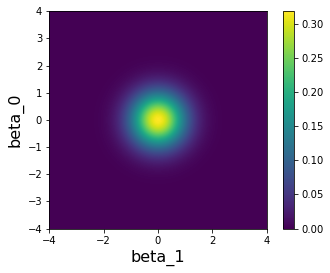

In [6]:
fig, ax = plt.subplots()
im = ax.imshow(prior_probs, origin="lower", cmap="viridis", extent=[theta_min, theta_max, theta_min, theta_max])
colorbar(im)

plt.xlabel("beta_1", fontsize=16)
plt.ylabel("beta_0", fontsize=16)
plt.grid(False)

It turns out that we do not have to rely on inverting the model with Bayesian inference directly. There exists an analytic update for the posterior distribution mean and covariance matrix. The equations are

$$
\begin{aligned}
    \boldsymbol{\Sigma}_{\theta \mid y} &=  (\sigma^{-2}_y \boldsymbol{X}^\top \boldsymbol{X} + \boldsymbol{\Sigma}^{-1}_{\theta} )^{-1} \\
    \boldsymbol{\mu}_{\theta \mid y} &= \boldsymbol{\Sigma}_{\theta \mid y}(\sigma^{-2}_y \boldsymbol{X}^\top \boldsymbol{y} + \boldsymbol{\Sigma}^{-1}_{\theta} \boldsymbol{\mu}_{\theta})
\end{aligned}
$$

We can easily implement these updates. To demonstrate this we create an agent class for Bayesian linear regression.

In [7]:
class BayesianLinearRegressionAgent:
    def __init__(self, params: dict) -> None:
        self.params = SimpleNamespace(**params)
    
    def build_data_matrix(self, X_star: np.ndarray) -> np.ndarray:
        return np.insert(X_star, 0, 1, axis=1)
    
    def infer_parameters(self, X_star: np.ndarray, y: np.ndarray):
        
        X = self.build_data_matrix(X_star)   # Turn X_star into a data matrix
        p_y = 1 / (self.params.std_y ** 2)   # Compute precision on y
        
        # Compute posterior mean and covariance matrix
        cov_posterior = inv(p_y * X.T @ X + inv(self.params.cov_theta))
        mean_posterior = cov_posterior @ (p_y * X.T @ y + inv(self.params.cov_theta) @ self.params.mu_theta)
        
        # Create posterior
        self.posterior = multivariate_normal.pdf(self.params.grid, mean_posterior, cov_posterior)

Next we will use the agent to infer parameters for different numbers of samples and plot the results.

In [8]:
# Agent parameters
agent_params = {
    "std_y"     : 1,                  # Standard deviation of sensory data
    "cov_theta" : 0.5 * np.eye(2),      # Theta covariance matrix [P x P]
    "mu_theta"  : np.array([0., 0.]),   # Theta prior [1 x P]
    "grid"      : create_grid(-4, 4)    # Theta grid
}

agent = BayesianLinearRegressionAgent(params=agent_params)

probs_list = [prior_probs]
samples = [1, 5, 10, 15, 50]

for s in samples:
    agent.infer_parameters(X_star[:s], y[:s])
    probs_list.append(agent.posterior)

<Figure size 432x288 with 0 Axes>

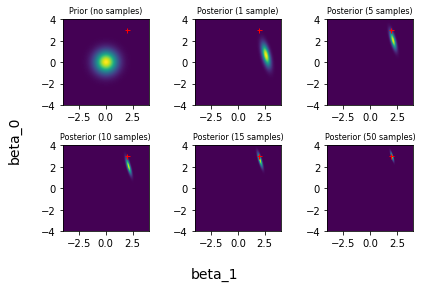

In [11]:
fig = plt.figure()
fig, axes = plt.subplots(2,3, facecolor=(1,1,1))

# Plot the distributions
for ax, data in zip(axes.reshape(-1), probs_list): 
    ax.imshow(data, origin="lower", cmap="viridis", extent=[theta_min, theta_max,theta_min, theta_max])
    ax.plot(2, 3, marker="+", color="red", markersize=5)
    ax.grid(False)

# Titles
axes[0,0].set_title("Prior (no samples)", fontsize=8)
axes[0,1].set_title("Posterior (1 sample)", fontsize=8)
axes[0,2].set_title("Posterior (5 samples)", fontsize=8)
axes[1,0].set_title("Posterior (10 samples)", fontsize=8)
axes[1,1].set_title("Posterior (15 samples)", fontsize=8)
axes[1,2].set_title("Posterior (50 samples)", fontsize=8)
    
fig.supxlabel("beta_1", fontsize=14)
fig.supylabel("beta_0", fontsize=14)   

fig.tight_layout()

As we can see, as we obtain more samples our distribution narrows and becomes more confident about the true values. 